# Using RNN for Texts Generation

In this notebook, we're going to follow the steps represented in [fast.ai lecture](http://course.fast.ai/lessons/lesson6.html) about recurrent neural networks but using **PyTorch** framework only. The main purpose is to show the internal structure of training loops and schedulers, to explain how you can build your own small tools and libraries to train deep learning models.

Note that in this notebook we use a set of simple custom wrappers build on top of **PyTorch** classes and functions. If you would like to see a "plain" version of the training loop, check [this script](./rnn_plain.py). 


## Impots and Global Variables

In [2]:
%matplotlib inline

In [3]:
import textwrap
from os.path import join, expanduser, exists
from urllib.error import URLError
from urllib.request import urlopen

In [4]:
import numpy as np
import pandas as pd

In [5]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchtext.data import Field

In [6]:
from core.text import TextDataset
from core.loop import Loop, Stepper
from core.iterators import SequenceIterator
from core.schedule import CosineAnnealingLR
from core.callbacks import EarlyStopping, Checkpoint, Logger, History

In [7]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [8]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

## Dataset Downloading

Use the following cell to download Nietzsche's texts as a single `.txt` file. Note that you'll need manually split the original file into training and validation subsets. The most simple way to do it is to use something similar to the following bash script:
```
$ cd data/nietzsche
$ mkdir train valid
$ cat nietzsche.txt | head -7000 > train/train.txt
$ cat nietzsche.txt | tail +7001 > valid/valid.txt
```

In [8]:
def download(url, download_path, expected_size):
    if exists(download_path):
        print('The file was already downloaded')
        return
    
    try:
        r = urlopen(url)
    except URLError as e:
        print(f'Cannot download the data. Error: {e}')
        return
    
    if r.status != 200:
        print(f'HTTP Error: {r.status}')
        return
    
    data = r.read()
    if len(data) != expected_size:
        print(f'Invalid downloaded array size: {len(data)}')
        return
    
    text = data.decode(encoding='utf-8')
    with open(download_path, 'w') as file:
        file.write(text)
        
    print(f'Downloaded: {download_path}')

In [9]:
# URL = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'
# PATH = expanduser(join('~', 'data', 'nietzsche', 'nietzsche.txt'))
# download(URL, PATH, 600901)

## Model Training

In [10]:
ROOT = expanduser(join('~', 'data', 'fastai', 'nietzsche'))
TRAIN_DIR = join(ROOT, 'trn')
VALID_DIR = join(ROOT, 'val')
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
class RNN(nn.Module):

    def __init__(self, vocab_size, n_factors, batch_size, n_hidden,
                 n_recurrent=1, dropout=0.5, architecture=nn.RNN,
                 device=DEVICE):

        self.vocab_size = vocab_size
        self.n_hidden = n_hidden
        self.n_recurrent = n_recurrent
        self.device = device

        super().__init__()
        self.embed = nn.Embedding(vocab_size, n_factors)
        self.rnn = architecture(
            n_factors, n_hidden, 
            num_layers=n_recurrent, dropout=dropout)
        self.out = nn.Linear(n_hidden, vocab_size)
        self.hidden_state = self.init_hidden(batch_size).to(device)
        self.batch_size = batch_size
        self.to(device)

    def forward(self, batch):
        bs = batch.size(1)
        if bs != self.batch_size:
            self.hidden_state = self.init_hidden(bs)
            self.batch_size = bs
        embeddings = self.embed(batch)
        rnn_outputs, h = self.rnn(embeddings, self.hidden_state)
        self.hidden_state = truncate_history(h)
        linear = self.out(rnn_outputs)
        return F.log_softmax(linear, dim=-1).view(-1, self.vocab_size)

    def init_hidden(self, batch_size):
        if type(self.rnn) == nn.LSTM:
            # an LSTM cell requires two hidden states
            h = torch.zeros(2, self.n_recurrent, batch_size, self.n_hidden)
        else:
            h = torch.zeros(self.n_recurrent, batch_size, self.n_hidden)
        return h.to(self.device)

In [12]:
def truncate_history(v):
    if type(v) == torch.Tensor:
        return v.detach()
    else:
        return tuple(truncate_history(x) for x in v)

In [13]:
def generate_text(model, field, seed, n=500):
    string = seed
    for i in range(n):
        indexes = field.numericalize(string)
        predictions = model(indexes.transpose(0, 1))
        last_output = predictions[-1]
        [most_probable] = torch.multinomial(last_output.exp(), 1)
        char = field.vocab.itos[most_probable]
        seed = seed[1:] + char
        string += char
    return string

In [14]:
def pretty_print(text, width=80):
    print('\n'.join(textwrap.wrap(text, width=width)))

In [15]:
def show_text(model, field, seed, n=500):
    pretty_print(generate_text(model, field, seed, n))

In [16]:
def create_dataset(bptt, batch_size, min_freq, new_lines=False):
    field = Field(lower=True, tokenize=list)
    dataset = TextDataset(field, min_freq, keep_new_lines=new_lines)
    factory = lambda seq: SequenceIterator(seq, bptt, batch_size)
    dataset.build(train=TRAIN_DIR, valid=VALID_DIR, iterator_factory=factory)
    return dataset, field

In [17]:
batch_size = 64
bptt = 32
min_freq = 3
n_hidden = 512
n_factors = 42
n_epochs = 100
n_recurrent = 2

In [57]:
dataset, field = create_dataset(bptt, batch_size, min_freq)

In [58]:
train_iters = dataset['train'].total_iters

In [59]:
callbacks = [
    EarlyStopping(patience=25),
    Checkpoint(),
    History(),
    Logger()
]

In [60]:
model = RNN(
    dataset.vocab_size,
    n_factors=n_factors,
    batch_size=batch_size,
    n_hidden=n_hidden,
    n_recurrent=n_recurrent,
    architecture=nn.LSTM)

optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = CosineAnnealingLR(optimizer, t_max=train_iters/2, eta_min=1e-6)
stepper = Stepper(model, optimizer, scheduler, F.nll_loss)

loop = Loop(stepper)

loop.run(train_data=dataset['train'],
         valid_data=dataset['valid'],
         callbacks=callbacks,
         epochs=n_epochs)

Epoch    1: train - 1.8331 valid - 1.3714
Epoch    2: train - 1.6067 valid - 1.5533
Epoch    3: train - 1.4359 valid - 1.4690
Epoch    4: train - 1.4699 valid - 1.5206
Epoch    5: train - 1.4214 valid - 1.4684
Epoch    6: train - 1.3372 valid - 1.4096
Epoch    7: train - 1.2690 valid - 1.3754
Epoch    8: train - 1.3652 valid - 1.4514
Epoch    9: train - 1.3973 valid - 1.4581
Epoch   10: train - 1.3675 valid - 1.4326
Epoch   11: train - 1.3262 valid - 1.4134
Epoch   12: train - 1.2815 valid - 1.3819
Epoch   13: train - 1.2408 valid - 1.3604
Epoch   14: train - 1.2130 valid - 1.3435
Epoch   15: train - 1.1957 valid - 1.3353
Epoch   16: train - 1.3098 valid - 1.4216
Epoch   17: train - 1.3870 valid - 1.4546
Epoch   18: train - 1.3962 valid - 1.4663
Epoch   19: train - 1.3712 valid - 1.4536
Epoch   20: train - 1.3479 valid - 1.4290
Epoch   21: train - 1.3241 valid - 1.4126
Epoch   22: train - 1.3003 valid - 1.3989
Epoch   23: train - 1.2758 valid - 1.3863
Epoch   24: train - 1.2552 valid -

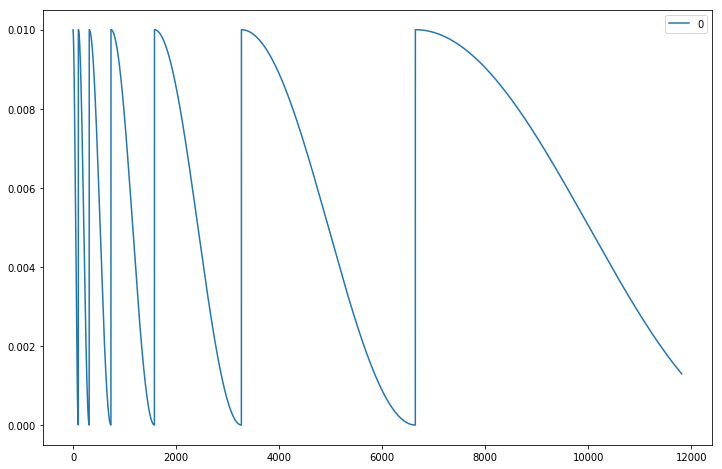

In [65]:
lrs = pd.DataFrame(loop.lr_schedule())
_ = lrs.plot(figsize=(12, 8))

In [66]:
path = loop['Checkpoint'].best_model
best_weights = torch.load(path)
model.load_state_dict(best_weights)

In [67]:
show_text(model, field, 'For thos')

For those landers from an its rast--for finds that it is--one may be required
thought lain the sers tin belief in the ennoble stiff outsotive philosophers in
its; thoi best above himself to truth (short, it still! his thought but the
myself one would say mires. the sentiments of interpretation, the extent; there
allow? therefore forms in assure a given else which, the warthing and thoughts,
as truth, three who, wherers. as a way which brows no instinct, a respect a
"either redestraise has tongated, neve


## Bonus: Custom Dataset

In [30]:
from pathlib import Path

In [31]:
DATA_ROOT = (Path.home() / 'data' / 'azlyrics').expanduser()
ARTISTS_DIR = DATA_ROOT / 'many'
DATASET_DIR = DATA_ROOT / 'lyrics'
TRAIN_DIR = DATASET_DIR / 'train'
VALID_DIR = DATASET_DIR / 'valid'

In [32]:
!rm -rf {DATASET_DIR}

In [33]:
index = 0
songs = []
for subfolder in ARTISTS_DIR.iterdir():
    artist = subfolder.name
    for filename in subfolder.glob('*.txt'):
        with open(filename) as file:
            content = file.read()
        songs.append((index, content))
        index += 1

np.random.shuffle(songs)
total = len(songs)
train_size = 0.8
train_count = int(total * train_size)

In [35]:
train_count

523

In [36]:
def move_songs(songs, destination):
    if not destination.exists():
        destination.mkdir(parents=True)
    for index, text in songs:
        filename = destination / f'{index}.txt'
        with open(filename, 'w') as file:
            file.write(text)

In [37]:
move_songs(songs[:train_count], TRAIN_DIR)

In [38]:
move_songs(songs[train_count:], VALID_DIR)

In [99]:
bptt = 32
batch_size = 64
min_freq = 20

field = Field(lower=True, tokenize=list)
dataset = TextDataset(field, min_freq, keep_new_lines=True)
factory = lambda seq: SequenceIterator(seq, bptt, batch_size)
dataset.build(train=TRAIN_DIR, valid=VALID_DIR, iterator_factory=factory)

In [100]:
train_iters = dataset['train'].total_iters

In [101]:
model = RNN(
    dataset.vocab_size,
    n_factors=50,
    batch_size=batch_size,
    n_hidden=512,
    n_recurrent=3,
    architecture=nn.LSTM)

callbacks = [
    EarlyStopping(patience=50),
    Logger(log_every=1),
    Checkpoint(),
    History()
]

optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = CosineAnnealingLR(optimizer, t_max=train_iters/4, cycle_mult=2, eta_min=1e-5)
stepper = Stepper(model, optimizer, scheduler, F.nll_loss)

loop = Loop(stepper)

loop.run(train_data=dataset['train'],
         valid_data=dataset['valid'],
         callbacks=callbacks,
         epochs=100)

Epoch    1: train - 2.5087 valid - 1.6703
Epoch    2: train - 2.0627 valid - 1.8893
Epoch    3: train - 1.6937 valid - 1.7633
Epoch    4: train - 1.6243 valid - 1.7094
Epoch    5: train - 1.5368 valid - 1.6298
Epoch    6: train - 1.4539 valid - 1.5566
Epoch    7: train - 1.4014 valid - 1.5042
Epoch    8: train - 1.4139 valid - 1.5321
Epoch    9: train - 1.4209 valid - 1.5287
Epoch   10: train - 1.3855 valid - 1.5062
Epoch   11: train - 1.3510 valid - 1.4801
Epoch   12: train - 1.3279 valid - 1.4504
Epoch   13: train - 1.2957 valid - 1.4327
Epoch   14: train - 1.2761 valid - 1.4110
Epoch   15: train - 1.2698 valid - 1.3990
Epoch   16: train - 1.2885 valid - 1.4402
Epoch   17: train - 1.3305 valid - 1.4612
Epoch   18: train - 1.3214 valid - 1.4629
Epoch   19: train - 1.3056 valid - 1.4600
Epoch   20: train - 1.2878 valid - 1.4475
Epoch   21: train - 1.2726 valid - 1.4370
Epoch   22: train - 1.2615 valid - 1.4234
Epoch   23: train - 1.2449 valid - 1.4131
Epoch   24: train - 1.2233 valid -

In [102]:
path = loop['Checkpoint'].best_model
best_weights = torch.load(path)
model.load_state_dict(best_weights)

In [109]:
print('Best model:', path)

Best model: /home/ck/code/pytorch_projects/model_valid_avg_loss_1.3530.weights


In [103]:
text = generate_text(model, field, 'Deep Song\n', n=250)

In [104]:
print(text)

Deep Song
please she had love in crazy star
you're take a samboridal horn to straight
it's already bleedin' of our angel - yeah
i do mentonanin singsithbost,
you're in mine
speakless inteceven toonst like you rain
you lived out
rhyme, i know
when dmine injose 


In [106]:
text = generate_text(model, field, 'Deep Song\n', n=200)
print(text)

Deep Song
hear the skip is right,
force like things that tite
you just see him color
you will leave me down, beggan' heart's burning up the life
so many way to give, carry on
there is gone for the night but i f


In [107]:
text = generate_text(model, field, 'Deep Song\n', n=500)
print(text)

Deep Song
waiting back the same old weak since"
i wanna see your frown
i was seen to school
face on down.
and when you made to be close away you now
she vnower that i never let you wonder than he never heard the black
you cannot give you history bang!
the last one night man
people we pray now
is the takes so are way to me cold
i walk on victims like they
caugat the sign on your love with the part
and the herous colon and sun to be
never look on where you heard a replies
or isn't faturing out
you were gonn
